In [1]:
import numpy as np
import time
import os
from VAEConv import VAEConvDec
import pickle
import gzip
import pdb
from dataloader import *
from optimizer import AdamOptimizer,RMSPROP,GDA
import pdb
import matplotlib.pyplot as plt


def GetImageToView(nphsvim):
    preToRGB= matplotlib.colors.hsv_to_rgb(nphsvim.reshape([192,128,3]))*255
    preToRGB[preToRGB<0] = 0
    preToRGB[preToRGB>255] = 255
    preToRGB2 = np.asarray(np.round(preToRGB),'uint8')
    return Image.fromarray(preToRGB2)

theano.config.dnn.conv.algo_bwd_filter="deterministic"
theano.config.dnn.conv.algo_bwd_data  ="deterministic"


"""
to have an output of 48x32 of a 3by3 filter with 2 pool => 48*2+3 =99   AND 32*2+3=67
to have an output of 99x67 from deconv of an input of 10*10 the w and h => 99-10+1=90   67-10+1=58 
hu_decoder':[(20,90,58,"dec"),(1,3,3,2,2,"conv")] to get 48*32
"""


path=os.path.expanduser("~/ModelOut/")

conf=pickle.load(open(path+'conf.pkl','rb'))


lamdaKL = conf['lamdaKL']
hu_encoder = conf['hu_encoder']
hu_decoder = conf['hu_decoder']
n_latent = conf['n_latent']
n_epochs = conf['n_epochs']

batch_size=conf['batch_size']
learning_rate = conf['learning_rate']

print ("Loading  data")
x_train,x_valid = GetData()

print ("Data was loaded")

sampleSize,featureSize = x_train.get_value().shape
# pdb.set_trace()
path = os.path.expanduser("~/ModelOut/")

print ("instantiating model")
rng = np.random.RandomState(42)
model = VAEConvDec(conf,rng,featureSize, hu_encoder, hu_decoder, n_latent, lamdaKL,
                  rows=192,cols=128,inpChannels=3)
# pdb.set_trace()
if conf['optim']=='rmsprop':
    optim = RMSPROP(model.params,learning_rate, batch_size=batch_size,decay_rate=conf['decay_rate'],l2=conf['l2'])
elif conf['optim']=='gda':
    optim = GDA(model.params,learning_rate, batch_size=batch_size,l2=conf['l2'])
else:
    optim = AdamOptimizer(model.params,learning_rate, sampleSize, 
        b1=conf['b1'], b2=conf['b2'], batch_size=batch_size,l2=conf['l2'])

# pdb.set_trace() 
tf_update= model.getUpdates(x_train,optim) #[batch,epoch,lr ]


batch_order = np.arange(int(sampleSize / batch_size))
epoch = 0
LB_list = []


model.load_parameters(path,optim)

genimage = model.decodeFromPrior()

getOut= theano.function([model.x],[model.layers[2].output_mu,
                                                model.layers[2].output_sig])
out=getOut(x_train.get_value())

Loading  data
Data was loaded
instantiating model
192 128
63 42
30 20
1 6 6
20 10 10


/home/hani/Repos/vae/characterds/VAEConv.py:726: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 1 is not part of the computational graph needed to compute the outputs: epoch.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  self.x: x_train[self.batch*optimizer.batch_size:(self.batch+1)*optimizer.batch_size, :]


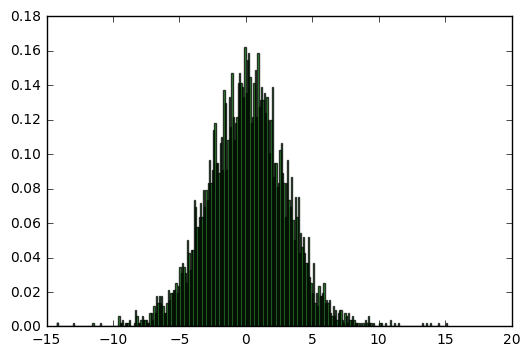

2.9593


In [10]:
model.trainmode.set_value(0.)
zs = model.getzvalues(x_valid.get_value())
n, bins, patches = plt.hist(zs.reshape([-1]), 300, normed=1, facecolor='green', alpha=0.75) 
plt.show()
np.mean(np.logical_and(zs.reshape(-1) >-2,  zs.reshape(-1)<2))
model.trainmode.set_value(1.)
print(np.std(zs.reshape([-1])))
model.trainmode.set_value(1.)

In [2]:
import matplotlib.pyplot as plt


genimage = model.decodeFromPrior(100)

model.trainmode.set_value(0.)
model.learningMode.set_value(0.)

mu,sigma,prior = genimage()

for i in range(100):
    img = GetImageToView(mu[i])
    img.save("/home/hani/Data/gen/characterDS/"+str(i)+".bmp")

model.learningMode.set_value(1.)
model.trainmode.set_value(1.)


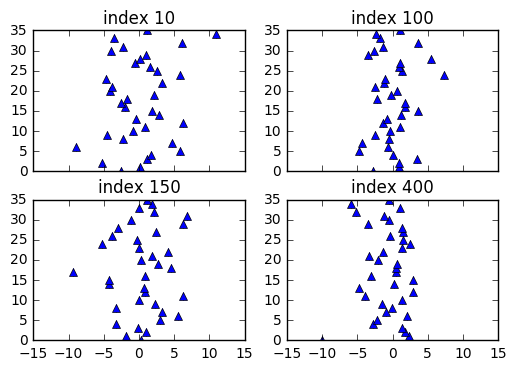

In [9]:
model.trainmode.set_value(0.)
model.learningMode.set_value(0.)
index=[10,100,150,400]
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True)
for i in range(2):
    for j in range(2):
        ax = axs[i,j]
        x = out[0][index[2*i+j]]
        y = np.arange(x.shape[0])
        #e = 2*np.sqrt(np.exp(out[1][2*i+j]))
        ax.errorbar(x, y, xerr=0, linestyle='None', marker='^')
        ax.set_title('index '+str(index[2*i+j]))
plt.show()
model.learningMode.set_value(1.)
model.trainmode.set_value(1.)

In [8]:
np.sqrt(np.exp(out[1][0]))

array([ 0.13068882,  0.06432988,  0.12614463,  0.11484045,  0.07131743,
        0.07263255,  0.04100469,  0.05158542,  0.14133337,  0.04469826,
        0.11023524,  0.13393968,  0.13477221,  0.11792876,  0.13712068,
        0.0843746 ,  0.09198786,  0.11532288,  0.1282296 ,  0.21183008,
        0.29335034,  0.12854405,  0.18273775,  0.07057364,  0.06086989,
        0.03477265,  0.10883841,  0.18854243,  0.25154176,  0.31483993,
        0.19016676,  0.15627697,  0.04700311,  0.06023839,  0.07124942,
        0.08733052], dtype=float32)